# Training a Food Classifier


## Load and prepare Data

Update the notebook to the latest version of fastai.

In [1]:
!pip install -Uqq fastai
from fastai.vision.all import *

At first we are downloading the [Food Dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), containing about 100k images of various kind of foods.

In [2]:
foodPath = untar_data(URLs.FOOD)

In [3]:
# how many images are we dealing with
len(get_image_files(foodPath))

101000

In [19]:
# parse the JSON as a human readable table
pd.read_json('/root/.fastai/data/food-101/test.json')

,churros,hot_and_sour_soup,samosa,sashimi,pork_chop,spring_rolls,panna_cotta,beef_tartare,greek_salad,foie_gras,...,chicken_quesadilla,pho,prime_rib,cheesecake,ice_cream,omelette,grilled_cheese_sandwich,lobster_roll_sandwich,nachos,oysters
0,churros/1061830,hot_and_sour_soup/1000486,samosa/1009326,sashimi/100113,pork_chop/1012227,spring_rolls/1005480,panna_cotta/1006650,beef_tartare/101073,greek_salad/1010850,foie_gras/1007306,...,chicken_quesadilla/10257,pho/1002382,prime_rib/1006976,cheesecake/1023543,ice_cream/1004744,omelette/1019294,grilled_cheese_sandwich/1000938,lobster_roll_sandwich/1002698,nachos/1011831,oysters/1005672
1,churros/1064042,hot_and_sour_soup/1004564,samosa/1024186,sashimi/1017182,pork_chop/1019077,spring_rolls/103010,panna_cotta/1027460,beef_tartare/1029120,greek_salad/1029680,foie_gras/1044237,...,chicken_quesadilla/1030292,pho/1020153,prime_rib/102197,cheesecake/102854,ice_cream/1031536,omelette/1058816,grilled_cheese_sandwich/1003050,lobster_roll_sandwich/1029665,nachos/101954,oysters/1017801
2,churros/1074903,hot_and_sour_soup/1011278,samosa/1036216,sashimi/1043094,pork_chop/102958,spring_rolls/1036175,panna_cotta/1030883,beef_tartare/1030025,greek_salad/1053670,foie_gras/1073688,...,chicken_quesadilla/1052529,pho/1026354,prime_rib/102813,cheesecake/1073148,ice_cream/1075106,omelette/1116874,grilled_cheese_sandwich/1005927,lobster_roll_sandwich/103891,nachos/103312,oysters/1019666
3,churros/1085259,hot_and_sour_soup/1029400,samosa/103689,sashimi/1050391,pork_chop/1040432,spring_rolls/1044858,panna_cotta/103712,beef_tartare/1031053,greek_salad/1062715,foie_gras/1113614,...,chicken_quesadilla/1096804,pho/1028507,prime_rib/1035695,cheesecake/1092082,ice_cream/1100243,omelette/1122818,grilled_cheese_sandwich/100694,lobster_roll_sandwich/104300,nachos/1044020,oysters/1040557
4,churros/1097261,hot_and_sour_soup/1044215,samosa/1052427,sashimi/10551,pork_chop/1045605,spring_rolls/1067952,panna_cotta/1050629,beef_tartare/1066933,greek_salad/1101710,foie_gras/1125178,...,chicken_quesadilla/1102036,pho/1029709,prime_rib/105375,cheesecake/1096018,ice_cream/1106165,omelette/1145379,grilled_cheese_sandwich/1052563,lobster_roll_sandwich/1046809,nachos/1060157,oysters/1044823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,churros/904526,hot_and_sour_soup/963551,samosa/917040,sashimi/889209,pork_chop/92293,spring_rolls/949343,panna_cotta/97960,beef_tartare/926143,greek_salad/949442,foie_gras/953456,...,chicken_quesadilla/921154,pho/964800,prime_rib/940800,cheesecake/970606,ice_cream/880755,omelette/955537,grilled_cheese_sandwich/942123,lobster_roll_sandwich/91688,nachos/962352,oysters/967284
246,churros/937430,hot_and_sour_soup/968546,samosa/929017,sashimi/893381,pork_chop/929555,spring_rolls/950371,panna_cotta/980326,beef_tartare/948352,greek_salad/961722,foie_gras/961263,...,chicken_quesadilla/924555,pho/965012,prime_rib/941938,cheesecake/972877,ice_cream/891533,omelette/97045,grilled_cheese_sandwich/942187,lobster_roll_sandwich/931310,nachos/98976,oysters/967288
247,churros/938480,hot_and_sour_soup/982582,samosa/937665,sashimi/938288,pork_chop/934946,spring_rolls/951951,panna_cotta/981405,beef_tartare/956509,greek_salad/968471,foie_gras/982330,...,chicken_quesadilla/9290,pho/982022,prime_rib/956130,cheesecake/996516,ice_cream/923525,omelette/978714,grilled_cheese_sandwich/975531,lobster_roll_sandwich/946365,nachos/99050,oysters/978125
248,churros/95272,hot_and_sour_soup/984258,samosa/960937,sashimi/981801,pork_chop/942955,spring_rolls/990689,panna_cotta/98261,beef_tartare/976175,greek_salad/995103,foie_gras/98353,...,chicken_quesadilla/94597,pho/990037,prime_rib/958647,cheesecake/996918,ice_cream/995145,omelette/979117,grilled_cheese_sandwich/977481,lobster_roll_sandwich/962425,nachos/99088,oysters/978925


In [20]:
# deciding which two foods we want to classify
labelA = 'samosa'
labelB = 'churros'

**Data Preparation**
1.   Remove all images that don't have labelA or labelB
2.   Rename images with labelA or labelB to have that label in their filename



In [21]:
# loop through all images downloaded
for img in get_image_files(foodPath):
  # rename images so that the label (Samosa or Churros) is in the file name
  if labelA in str(img):
    img.rename(f"{img.parent}/{labelA}-{img.name}")
  elif labelB in str(img):
    img.rename(f"{img.parent}/{labelB}-{img.name}")
  else: os.remove(img) # if the Images are not part of labelA or labelB

len(get_image_files(foodPath))

1000

## Train Model

In [22]:
def GetLabel(fileName):
  return fileName.split('-')[0]

# test function
GetLabel("churros-734186.jpg")

'churros'

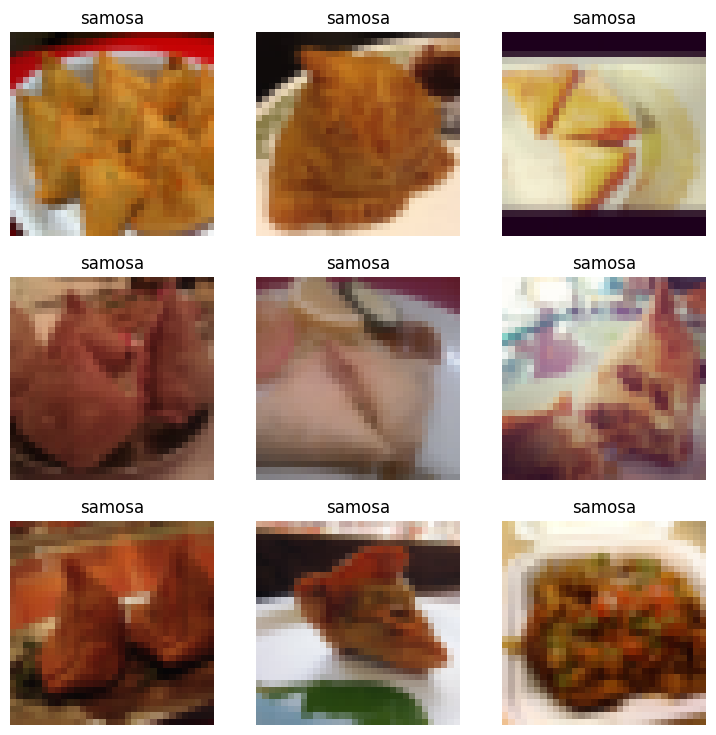

In [23]:
dls = ImageDataLoaders.from_name_func(
    foodPath, get_image_files(foodPath), valid_pct=0.2, seed=420,
    label_func=GetLabel, item_tfms=Resize(32))

dls.train.show_batch()

In [24]:
learn = cnn_learner(dls, resnet34, metrics=error_rate, pretrained=True)
learn.fine_tune(epochs=1)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:04


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:05


## Verify Model

### Test using images in dataset

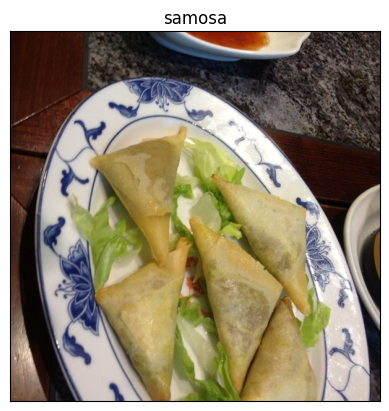

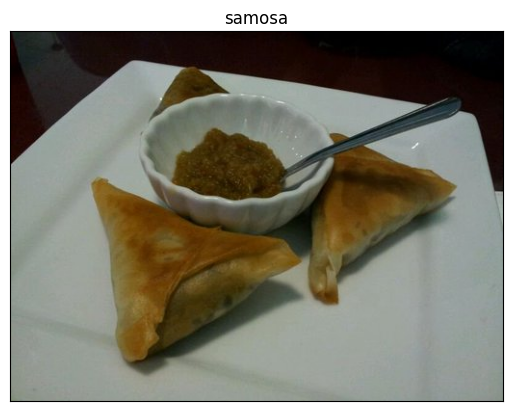

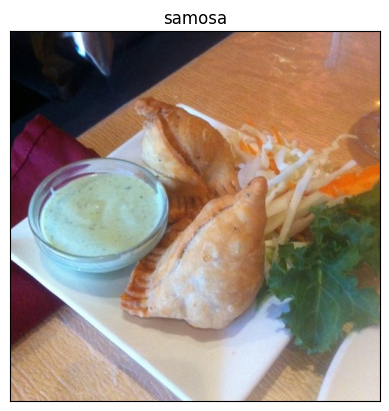

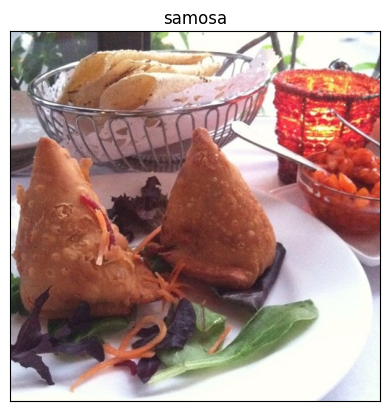

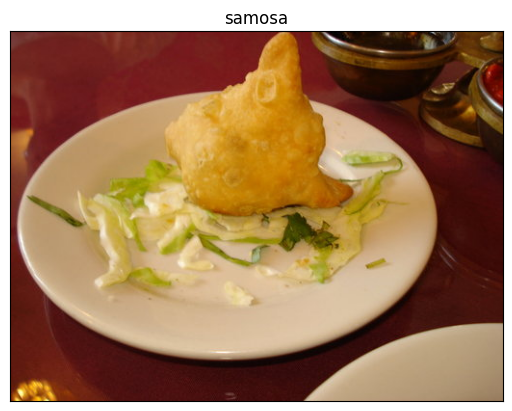

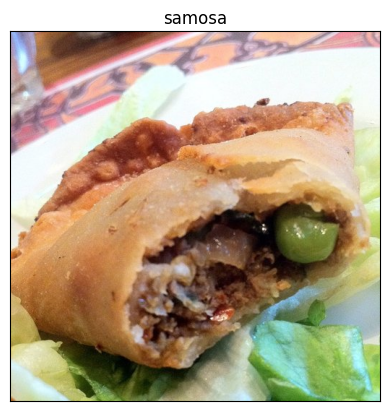

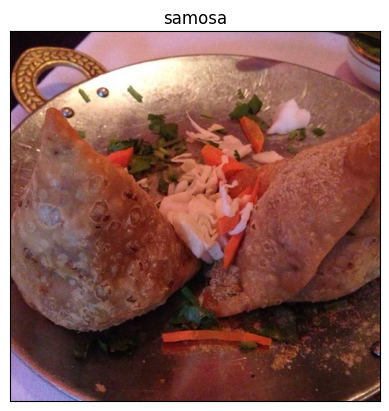

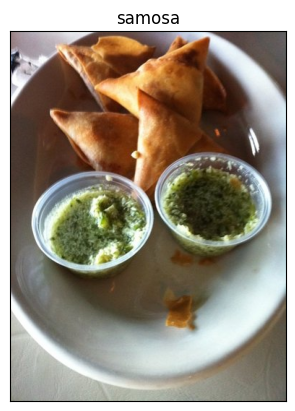

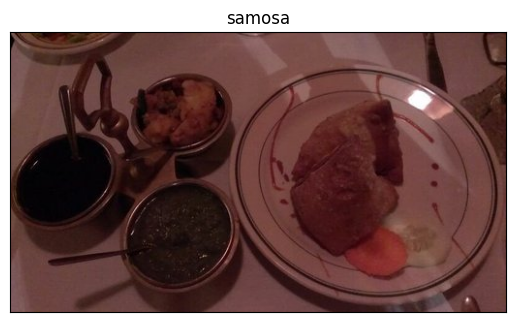

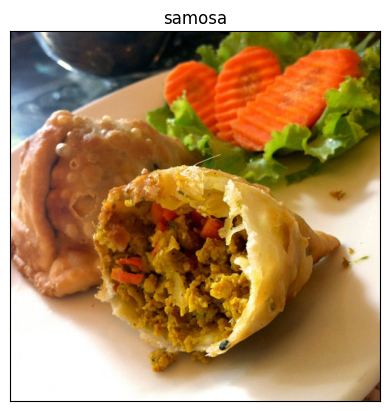

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(0,10):
  # load random image
  randomIndex = random.randint(0, len(get_image_files(foodPath))-1)
  img = mpimg.imread(get_image_files(foodPath)[randomIndex])
  # put into Model
  label,_,probs = learn.predict(img)

  # create figure using matplotlib
  fig = plt.figure()
  ax = fig.add_subplot() # add subplot (For multiple images)
  imgplot = plt.imshow(img) # add image into plot
  ax.set_title(label) # set headline to predicted label

  # hide numbers on axes
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)

### Confusion Matrix

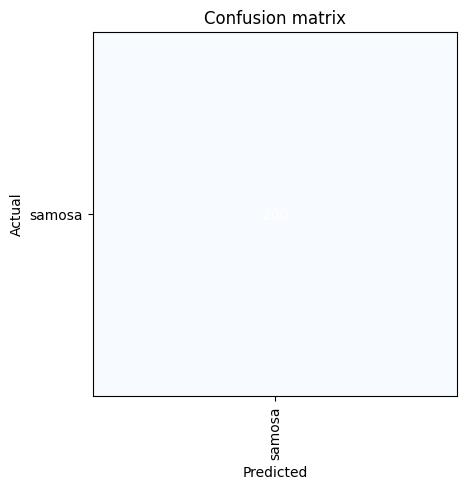

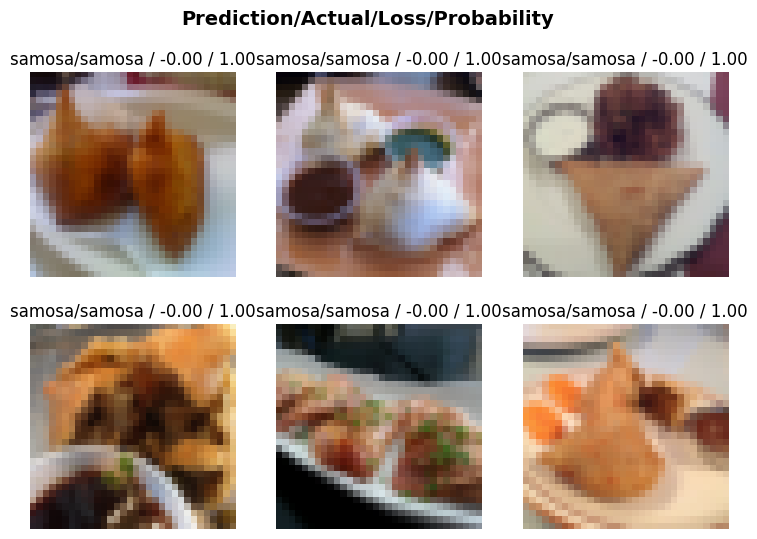

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(6)

## Deploy

In [33]:
learn.export() # exports model as 'export.pkl' by default

In [34]:
# grab the first pkl file we can find
modelPath = get_files(foodPath, '.pkl')[0]
modelPath

Path('/root/.fastai/data/food-101/export.pkl')

In [35]:
learn_inf = load_learner(modelPath)
learn_inf.predict(mpimg.imread(get_image_files(foodPath)[0])) # raw prediction

('samosa', tensor(0), tensor([1.]))

In [36]:
learn_inf.dls.vocab # get the labels

['samosa']

In [37]:
from google.colab import files
files.download(modelPath)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>